# Notebook de diseño de la Red Predictiva Fintech_LSTM

### Celdas de carga de librerías, paquetes, etc...

In [1]:
####################################################################################
# PASO 1: Importar todos los módulos necesarios
import sys
ENABLE_GOOGLE_COLAB = 'google.colab' in sys.modules
ENABLE_GOOGLE_COLAB

False

In [2]:
####################################################################################
if ENABLE_GOOGLE_COLAB:
  # Instalación de API de Google Drive para utilizar archivos en la nube
  !pip install -U -q PyDrive
  # Instala h5py
  !pip install h5py
  # Instala plot.ly
  !pip install plotly
  # TA-Lib: instalación y carga de la librería
  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  !make
  !make install
  !pip install Ta-Lib
  # Instalación de ngrok para visualización en tensorboard
  !wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
  !unzip ngrok-stable-linux-amd64.zip
  from google.colab import auth
  from google.colab import files
  
####################################################################################
# incluye google drive api
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from oauth2client.client import GoogleCredentials

####################################################################################
# Librerías de manejo de datos 
import pandas as pd
from pandas import concat
import numpy as np

####################################################################################
# Librerías de machine learning
import sklearn
from sklearn import preprocessing
from sklearn import metrics as sk
import keras
from keras.models import Model
from keras.layers import Input, LSTM, Dense
from keras.optimizers import Adam
from keras.callbacks import TensorBoard

####################################################################################
# Librerías de visualización
import matplotlib.pyplot as plt
from matplotlib import dates, ticker
from matplotlib.dates import (MONDAY, DateFormatter, MonthLocator, WeekdayLocator, date2num)
import matplotlib as mpl
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.graph_objs import Scatter, Layout
import plotly.tools as tls
tls.set_credentials_file(username='raulMrello', api_key='qX9S30YRQ866mGF9b89u')

####################################################################################
# TA-Lib: instalación y carga de la librería
import talib

####################################################################################
# Otras utilidades
import datetime
import time
import os
import sys
import math

####################################################################################
print('Done!')

Using TensorFlow backend.


Done!


In [3]:
####################################################################################
# PASO 2a (google colab): Autenticación en Google Drive para obtener el archivo csv
if ENABLE_GOOGLE_COLAB:
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)
  #2. Obtiene el archivo
  downloaded = drive.CreateFile({'id':'12syio4J4xs-PFo_qNNWsNKvQhZb0nOaY'}) # replace the id with id of file you want to access
  downloaded.GetContentFile('EURUSD_H1.csv')  
  #downloaded = drive.CreateFile({'id':'1xuDgK4FteolMBiaYVRNWaofw36iQyRaV'}) # replace the id with id of file you want to access
  #downloaded.GetContentFile('EURUSD_M30.csv')  
  #downloaded = drive.CreateFile({'id':'18o564BOnayxVbbY2DR7BjGXY-zzk9PBd'}) # replace the id with id of file you want to access
  #downloaded.GetContentFile('test_fourier.csv')  

### Celdas de carga de datos históricos desde archivo csv a Pandas Dataframe

- Cargo el histórico en dataframe
- Puedo reindexar el timestamp a una cadencia fija (ej. 1 hora) y rellenar los gaps (NaN)
- Puedo visualizar el resultado en forma de gráfico de velas

         DATE      TIME    OPEN    HIGH     LOW   CLOSE  TICKVOL  VOL  SPREAD
0  2001.01.01  00:00:00  0.9421  0.9423  0.9419  0.9419        5    0      50
1  2001.01.01  08:00:00  0.9422  0.9424  0.9422  0.9424        2    0      50
2  2001.01.01  14:00:00  0.9425  0.9425  0.9425  0.9425        1    0      50
3  2001.01.01  15:00:00  0.9419  0.9419  0.9419  0.9419        1    0      50
4  2001.01.01  18:00:00  0.9397  0.9399  0.9390  0.9395       20    0      50 
--------------------------
         DATE      TIME    OPEN    HIGH     LOW   CLOSE  TICKVOL  VOL  SPREAD  \
0  2001.01.01  00:00:00  0.9421  0.9423  0.9419  0.9419        5    0      50   
1  2001.01.01  08:00:00  0.9422  0.9424  0.9422  0.9424        2    0      50   
2  2001.01.01  14:00:00  0.9425  0.9425  0.9425  0.9425        1    0      50   
3  2001.01.01  15:00:00  0.9419  0.9419  0.9419  0.9419        1    0      50   
4  2001.01.01  18:00:00  0.9397  0.9399  0.9390  0.9395       20    0      50   

            times

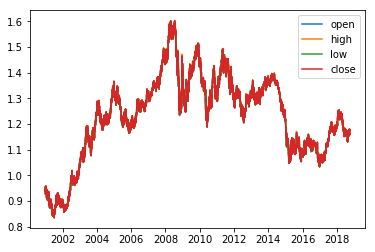

In [4]:
####################################################################################
# PASO 3: Carga el archivo csv en un dataframe, con posibilidad de rellenar espacios vacíos
def load_hist(filename, **kwargs):
    '''
        :param filename Archivo csv a leer
        :param kwargs lista de opciones:
            sep CSV Separator
            reindex_fillna Flag para rellenar espacios en blanco
            plot_it Flag para visualizar el archivo
        :return dataframe creado
    '''
    sep = ','
    reindex_fillna=False
    plot_it=False    
    if kwargs is not None:
        for key, value in kwargs.items():
            if key == 'sep': sep = value
            if key == 'reindex_fillna': reindex_fillna = value
            if key == 'plot_it': plot_it = value
                
    df = pd.read_csv(filename, sep=sep) 
    print(df.head(),'\r\n--------------------------')
    # crea una nueva columna de timestamp uniendo date & time y crea columnas para el día de la semana, el día del mes, el mes y la hora del día actual 
    df['timestamp'] = df['DATE'] + '  ' + df['TIME'] 
    df['timestamp'] = df['timestamp'].map(lambda x: datetime.datetime.strptime(x, '%Y.%m.%d %H:%M:%S'))  
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    print(df.head(),'\r\n--------------------------')
    # establece como índice la columna de timestamp con una cadencia de 30min para encontrar los valores NaN
    if reindex_fillna:
        df.set_index('timestamp', inplace=True)
        df = df.reindex(pd.date_range(min(df.index), max(df.index), freq="1H"))
        # elimina los valores nulos y los rellena con el valor anterior
        df.fillna(method='ffill', inplace =True)
    df['weekday'] = df.index.dayofweek
    df['day'] = df.index.day
    df['month'] = df.index.month
    df['hhmm'] = df.index.hour*60 +df.index.minute
    df['barsize'] = df['CLOSE']-df['OPEN']
    df = df[['OPEN','HIGH','LOW','CLOSE','barsize','hhmm','weekday','TICKVOL','VOL','SPREAD']]
    print(df.head())
            
    if plot_it:
        plt.plot(df.OPEN)
        plt.plot(df.HIGH)
        plt.plot(df.LOW)
        plt.plot(df.CLOSE)
        plt.legend(['open','high','low','close'], loc='upper right')        
    return df
        
    
####################################################################################
####################################################################################

df = load_hist('EURUSD_H1.csv',sep=';', reindex_fillna=True, plot_it=True)    

enable_plot_candles = False
if enable_plot_candles:
    # visualizo una sección
    trace = go.Candlestick(x=df.index[-100:],
                                   open=df.OPEN[-100:],
                                   high=df.HIGH[-100:],
                                   low=df.LOW[-100:],
                                   close=df.CLOSE[-100:])
    data = [trace]
    layout = go.Layout(
        autosize=False,
        width=1000,
        height=700,    
        title='Mostrando últimos 100 datos',
    )
    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig)

###  Elaboración de indicadores técnicos sintéticos

A partir de los datos OHLC, y la librería TA-Lib genero diversos indicadores sintéticos. En este caso he optado por predecir el precio de cierre 'close' y por lo tanto, todos los indicadores se aplicarán a dicho precio (aunque se podrían utilizar otros precios como 'high', 'low', 'open', etc...).

- bollWidthRel: Aporta la anchura de las bandas bollinger relativa a su propia SMA100
- bollR: Aporta la posición del precio en relación a la banda bollinger en %
- atr: Aporta la diferencia entre éste y el cierre de la sesión anterior
- SMAx3: Aporta 3 medias simples de 4,16 y 40 periodos
- Además también puedo añadir el propio precio ('close')

,barsize,bollWidthRel_CLOSE,bollR_CLOSE,atr_CLOSE,sma4_CLOSE,sma16_CLOSE,sma40_CLOSE,CLOSE,out
2001-01-03 20:00:00,-0.0036,0.863983,-0.247251,-0.001500,0.938950,0.948537,0.947213,0.9297,0.9297
2001-01-03 21:00:00,-0.0008,0.984695,-0.109007,-0.001579,0.934300,0.947169,0.946955,0.9290,0.9290
2001-01-03 22:00:00,-0.0019,1.068522,-0.048342,-0.001621,0.929825,0.945694,0.946655,0.9271,0.9271
2001-01-03 23:00:00,0.0006,1.100524,0.042001,-0.001871,0.928350,0.944225,0.946383,0.9276,0.9276
2001-01-04 00:00:00,0.0010,1.095071,0.118506,-0.001843,0.928075,0.942900,0.946040,0.9286,0.9286


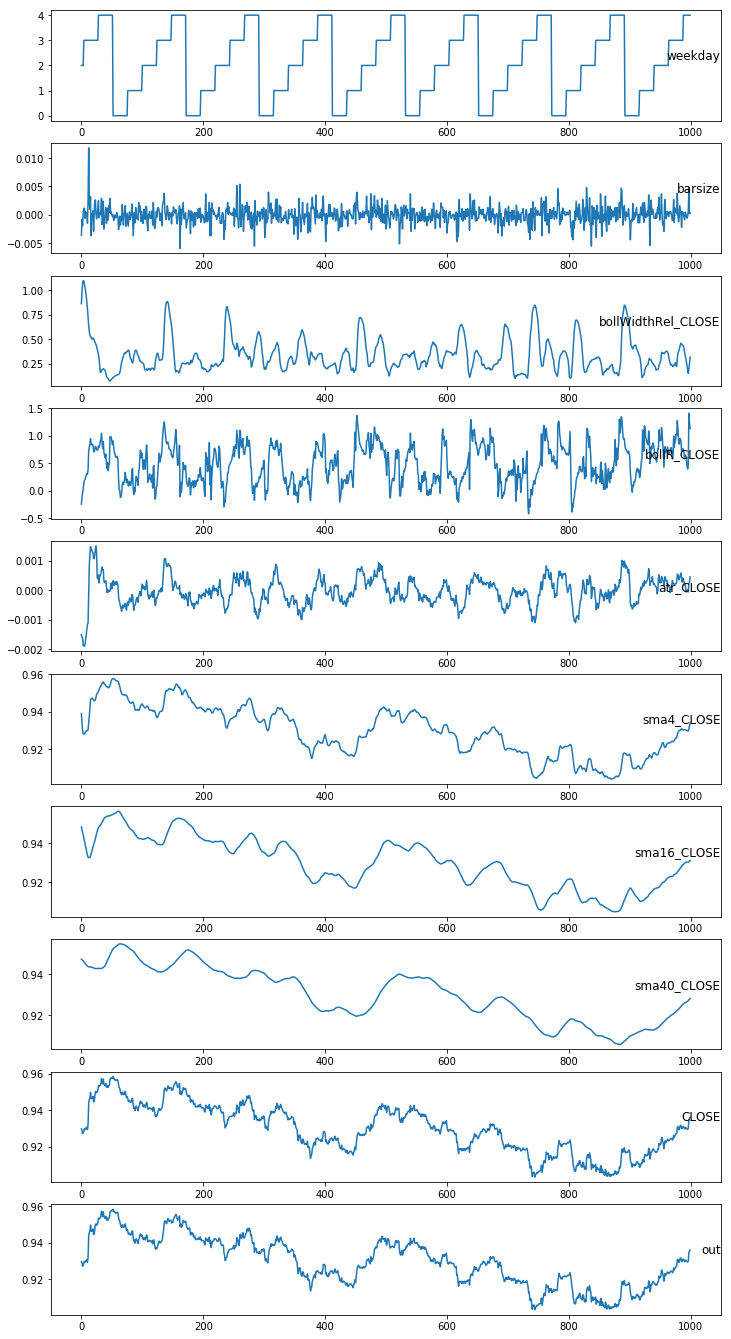

In [5]:
####################################################################################
# PASO 4: Crea columnas para diferentes indicadores TA-Lib, descarta el resto de columnas
def add_indicators(df, out_applied, applied, add_cols, sub_cols, indicators, **kwargs):
    '''
        :param df DataFrame de referencia
        :param applied Lista de precios a los que aplicar los indicadores
        :param indicators Lista de los indicadores a formar:
                    bollWidthRel - Anchura bandas bollinger relativa a la sma100 de la anchura
                    bollR - Posición del precio en la banda en %
                    atr - Average true range standar
                    SMAx3 - Triple media móvil superpuestas dos a dos
                    CLOSE - Datos en columna df.CLOSE
        :return dataframe actualizado
    '''
    df = df.copy()    
    
    plot_it = False
    starts = 0    
    plot_len = 0
    remove_weekends=False
    for key,val in kwargs.items():        
        if key=='plot_it': plot_it=val
        elif key=='starts': starts=val
        elif key=='plot_len': plot_len=val
        elif key=='remove_weekends':
            remove_weekends=val
    if remove_weekends:
        df = df.drop(df[(df['weekday'] > 4)].index)
            
    cols = list()
    cols = cols + add_cols
    for p in applied:
        if df[p] is None: continue
        upperband, middleband, lowerband = talib.BBANDS(df[p], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
        bollinger_width = upperband - lowerband
        sma8 = talib.SMA(df[p], timeperiod=8)
        sma50 = talib.SMA(df[p], timeperiod=50)
        sma100 = talib.SMA(df[p], timeperiod=100)    
        for i in indicators:
            if i+'_'+p in df.columns:
                continue                
            if i=='bollWidthRel':
                # obtengo columnas a partir de features TA-Lib            
                bollinger_width_sma50 = talib.SMA(bollinger_width, timeperiod=50)            
                df[i+'_'+p] = bollinger_width/(3*bollinger_width_sma50)
                cols.append(i+'_'+p)
                
            elif i=='bollR':
                if i+'_'+p in df.columns:
                    continue                
                bollR = (df[p] - lowerband)/(upperband - lowerband)
                bollR[np.isnan(bollR)]=0.5
                bollR[np.isinf(bollR)]=0.5
                df[i+'_'+p]=bollR
                cols.append(i+'_'+p)
                
            elif i=='atr':
                df[i+'_'+p] = talib.SMA((df[p] - df.CLOSE.shift(1)),timeperiod=14)
                cols.append(i+'_'+p)
              
            elif i=='SMAx3':            
                df['sma4_'+p] = talib.SMA(df.CLOSE,timeperiod=4)
                df['sma16_'+p] = talib.SMA(df.CLOSE,timeperiod=16)
                df['sma40_'+p] = talib.SMA(df.CLOSE,timeperiod=40)
                cols.append('sma4_'+p)
                cols.append('sma16_'+p)
                cols.append('sma40_'+p)
              
            elif i=='BarSizeSma':            
                barsize_sma = talib.SMA(df['barsize'],timeperiod=20)
                df['BarSizeSma'] = df['barsize']/barsize_sma
                cols.append('BarSizeSma')
                
            elif i=='HIGH' or i=='LOW' or i== 'CLOSE' or i=='OPEN':
                if i in cols:
                    continue                
                cols.append(i)
                
            else:  
                print('Indicador "{}" desconocido'.format(i))                    
        
    for key,val in kwargs.items():        
        if key=='add_applied':
            for i in applied:
                cols.append(i)
    
    df[out_applied] = df[applied[0]]
    cols.append(out_applied)
    df = df[cols]    
    df.dropna(inplace=True)   
    dfview = df
    if remove_weekends:
        dfview = df.reset_index()

    if plot_it:
        plt.figure(figsize=(12,24))
        for i in cols:
            plt.subplot(len(cols), 1, cols.index(i)+1)
            plt.plot(dfview[i][starts:starts+plot_len])
            plt.title(i, y=0.5, loc='right')
    df = df.drop(sub_cols,axis=1)
    return df

####################################################################################
####################################################################################
columns_to_include = ['weekday', 'barsize'] #['hhmm','weekday','barsize']
indicators_to_generate = ['bollWidthRel', 'bollR', 'atr', 'SMAx3']
columns_to_exclude = ['weekday']
dfapp = add_indicators(df, 'out',['CLOSE'], columns_to_include, columns_to_exclude, indicators_to_generate, remove_weekends=True, add_applied=True, plot_it=True, starts=0, plot_len=1000)
dfapp.head()



###  Adaptación de los datos para realizar un entrenamiento supervisado 

Los datos vienen dados para cada timestamp, sin embargo la red neuronal espera un formato distinto, del tipo:

x: (num_samples, loopback_wdow, num_inputs)
y: (num_outputs * forecast_wdow)

En este caso, las entradas van a ser los diferentes indicadores aplicados al precio 'close' y las salidas serán las predicciones para ese precio 'close':

- Se utilizarán datos de las últimas 24 sesiones y se predecirán los de las 4 siguientes
- Las entradas serán cada uno de los indicadores anteriores, además del precio.
- La salida será la predicción del precio para esas 4 sesiones

In [6]:
####################################################################################
# PASO 5: Crea time-steps de las entradas y las salidas para la red LSTM
def series_to_supervised(df, num_inputs, num_outputs, n_in=1, n_out=1, dropnan=True):
  # obtengo el dataframe con las entradas y las salidas
  df_in = df[[x for x in df.columns if df.columns.get_loc(x) < num_inputs]]
  df_out = df[[x for x in df.columns if df.columns.get_loc(x)>=num_inputs]]
  
  cols, names = list(), list()
	# input sequence (t-n, ... t-1)
  for i in range(n_in-1, -1, -1):
    cols.append(df_in.shift(i))
    if i!=0:
      names += [('%s(t-%d)' % (df_in.columns[j], i)) for j in range(0, num_inputs)]
    else:
      names += [('%s(t)' % (df_in.columns[j])) for j in range(0, num_inputs)]
    
	# forecast sequence (t, t+1, ... t+n)
  for i in range(1, n_out+1):   
    cols.append(df_out.shift(-i))
    if i == 0:
      names += [('%s(t)' % (df_out.columns[j])) for j in range(0, num_outputs)]
    else:
      names += [('%s(t+%d)' % (df_out.columns[j], i)) for j in range(0, num_outputs)]
  # put it all together
  agg = concat(cols, axis=1)
  agg.columns = names
  # drop rows with NaN values
  if dropnan:
    agg.dropna(inplace=True)
  return agg

####################################################################################
####################################################################################

# Creo columnas para las 24 muestras de entradas t-1, ..., t-48 y para las dos salidas t, t+1
num_in_steps = 46
num_out_steps = 2
num_outputs = 1
num_inputs = dfapp.shape[1] - num_outputs
sts_df = series_to_supervised(dfapp, num_inputs, num_outputs, num_in_steps, num_out_steps)
print('Número de muestras total: ', sts_df.shape[0])
sts_df.head()

Número de muestras total:  111006


,barsize(t-45),bollWidthRel_CLOSE(t-45),bollR_CLOSE(t-45),atr_CLOSE(t-45),sma4_CLOSE(t-45),sma16_CLOSE(t-45),sma40_CLOSE(t-45),CLOSE(t-45),barsize(t-44),bollWidthRel_CLOSE(t-44),...,barsize(t),bollWidthRel_CLOSE(t),bollR_CLOSE(t),atr_CLOSE(t),sma4_CLOSE(t),sma16_CLOSE(t),sma40_CLOSE(t),CLOSE(t),out(t+1),out(t+2)
2001-01-05 17:00:00,-0.0036,0.863983,-0.247251,-0.001500,0.938950,0.948537,0.947213,0.9297,-0.0008,0.984695,...,0.0017,0.084968,0.449904,-0.000014,0.952950,0.954181,0.947890,0.9534,0.9539,0.9569
2001-01-05 18:00:00,-0.0008,0.984695,-0.109007,-0.001579,0.934300,0.947169,0.946955,0.9290,-0.0019,1.068522,...,0.0005,0.073500,0.496481,-0.000043,0.953325,0.954213,0.948505,0.9539,0.9569,0.9573
2001-01-05 19:00:00,-0.0019,1.068522,-0.048342,-0.001621,0.929825,0.945694,0.946655,0.9271,0.0006,1.100524,...,0.0029,0.072458,0.980781,-0.000029,0.954175,0.954419,0.949183,0.9569,0.9573,0.9578
2001-01-05 20:00:00,0.0006,1.100524,0.042001,-0.001871,0.928350,0.944225,0.946383,0.9276,0.0010,1.095071,...,0.0003,0.080092,0.970775,0.000121,0.955375,0.954594,0.949855,0.9573,0.9578,0.9576
2001-01-05 21:00:00,0.0010,1.095071,0.118506,-0.001843,0.928075,0.942900,0.946040,0.9286,0.0012,1.064460,...,0.0005,0.087993,0.972166,0.000243,0.956475,0.954625,0.950535,0.9578,0.9576,0.9575


In [7]:
####################################################################################
# PASO 6: Aplicar lo que se necesite a las salidas o no hacer nada en caso contrario
sts_src = sts_df.copy()
# sts_src contiene el dataframe original sin escalado y con todas las columnas más representativas
#sts_src.to_csv('sts_src.csv', sep=';')

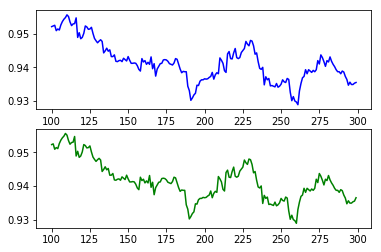

In [11]:
####################################################################################
# PASO 7: Chequeo de los datos antes de su selección y normalización para la red neuronal 
i,j=100,300
plt.subplot(2,1,1)
plt.plot(sts_src.reset_index()['CLOSE(t)'][i:j],color='b')
plt.subplot(2,1,2)
plt.plot(sts_src.reset_index()['out(t+1)'][i:j],color='g')



### Normalización de los datos de entrada-salida

A continuación, se realiza la selección final de columnas del dataframe que se utilizará en la red neuronal y los datos se normalizarán utilizando un 'scaler' concreto. Dicho scaler se utilizará tras el proceso de predicción, para volver a de-normalizar el resultado y obtener su valor real.

In [14]:
####################################################################################
# PASO 9: Creo los scalers de cada columna seleccionada
sts_src_values = sts_src.values
sts_src_values = sts_src_values.astype('float32')
scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
sts_src_scaled_values = scaler.fit_transform(sts_src_values)

# actualizo el dataframe
sts_scaled = pd.DataFrame(data=sts_src_scaled_values, columns=sts_src.columns, index=sts_src.index)
sts_scaled_values = sts_scaled.values
#sts_scaled.to_csv('sts_scaled.csv', sep=';')
sts_scaled.head()


,barsize(t-45),bollWidthRel_CLOSE(t-45),bollR_CLOSE(t-45),atr_CLOSE(t-45),sma4_CLOSE(t-45),sma16_CLOSE(t-45),sma40_CLOSE(t-45),CLOSE(t-45),barsize(t-44),bollWidthRel_CLOSE(t-44),...,barsize(t),bollWidthRel_CLOSE(t),bollR_CLOSE(t),atr_CLOSE(t),sma4_CLOSE(t),sma16_CLOSE(t),sma40_CLOSE(t),CLOSE(t),out(t+1),out(t+2)
2001-01-05 17:00:00,-0.229091,-0.243371,-0.685724,-0.531823,-0.730614,-0.706189,-0.715587,-0.754537,-0.127273,-0.137657,...,-0.036364,-0.925602,-0.045971,-0.083064,-0.693954,-0.691376,-0.713793,-0.692649,-0.691344,-0.683510
2001-01-05 18:00:00,-0.127273,-0.137657,-0.558863,-0.555556,-0.742791,-0.709782,-0.716269,-0.756365,-0.167273,-0.064244,...,-0.080000,-0.935645,-0.003229,-0.091694,-0.692973,-0.691294,-0.712164,-0.691344,-0.683510,-0.682465
2001-01-05 19:00:00,-0.167273,-0.064244,-0.503194,-0.568501,-0.754509,-0.713653,-0.717064,-0.761327,-0.076364,-0.036218,...,0.007273,-0.936558,0.441195,-0.087379,-0.690747,-0.690753,-0.710369,-0.683510,-0.682465,-0.681159
2001-01-05 20:00:00,-0.076364,-0.036218,-0.420289,-0.644013,-0.758371,-0.717508,-0.717786,-0.760021,-0.061818,-0.040994,...,-0.087273,-0.929873,0.432012,-0.042071,-0.687604,-0.690294,-0.708588,-0.682465,-0.681159,-0.681682
2001-01-05 21:00:00,-0.061818,-0.040994,-0.350083,-0.635383,-0.759091,-0.720986,-0.718693,-0.757409,-0.054545,-0.067801,...,-0.080000,-0.922953,0.433289,-0.005394,-0.684724,-0.690212,-0.706787,-0.681159,-0.681682,-0.681943


In [16]:
# guardo el scaler en disco

from sklearn.externals import joblib
scaler_filename = "scaler.save"
joblib.dump(scaler, scaler_filename) 


['scaler.save']

<Figure size 432x288 with 0 Axes>

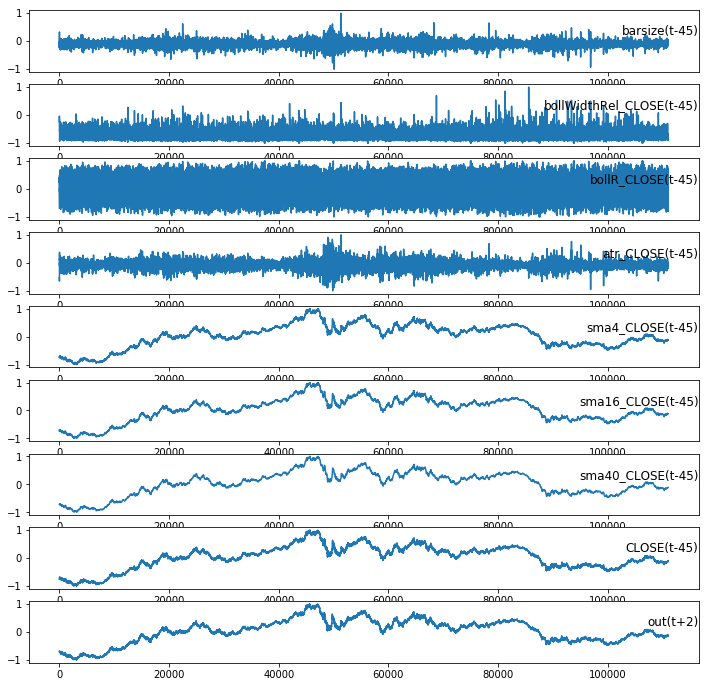

In [17]:
####################################################################################
# PASO 10 (opcional): Visualización de entradas y salidas escaladas
plt.figure()
plots = num_inputs + num_outputs
plt.figure(figsize=(12,12))
for col in range(num_inputs):
  plt.subplot(plots, 1, col+1)
  plt.plot(sts_scaled_values[:, col])
  plt.title(sts_scaled.columns[col], y=0.5, loc='right')
for col in range(num_outputs):
  plt.subplot(plots, 1, num_inputs+col+1)
  plt.plot(sts_scaled_values[:, -num_outputs+col])
  plt.title(sts_scaled.columns[-num_outputs+col], y=0.5, loc='right')


### Preparación de los pares entrenamiento-validación y test

El dataframe normalizado 'sts_scaled' se divide en dos grupos:     |------ train&validate------|-- test --|
A continuación se calculan los tamaños de las ventanas de walk-forward:

|--------- wdow_train_validate ---------|
|----- wdow_train -----|-- wdow_valid --|
        |----- wdow_train -----|-- wdow_valid --|
                |----- wdow_train -----|-- wdow_valid --|
                        ...


In [18]:
# establece un batch_size para que todo sea un múltiplo de éste
batch_size = 15
# establezco un ratio train-validation de (80%, 20%), para lo que tomo bloques de 5 batches: 4-train 1-validate
wf_train = 4 * batch_size
wf_validate = 1 * batch_size
# calculo el número de muestras train-validate para que sea un múltiplo entero de 5 batches
wf_forward = wf_train + wf_validate
total_samples = sts_scaled.shape[0]
trvl_ratio = 0.8
trvl_samples = total_samples * trvl_ratio
num_blocks = int(trvl_samples/wf_forward)
trvl_samples = num_blocks * wf_forward
test_samples = total_samples - trvl_samples
print('Total samples............... ', total_samples)
print('Train-Validate samples...... ', trvl_samples)
print('Num blocks.................. ', num_blocks)
print('Train per block............. ', wf_train)
print('Validate per block.......... ', wf_validate)
print('Total trains................ ', wf_train * num_blocks)
print('Total validates............. ', wf_validate * num_blocks)


Total samples...............  111006
Train-Validate samples......  88800
Num blocks..................  1184
Train per block.............  60
Validate per block..........  15
Total trains................  71040
Total validates.............  17760


In [19]:
####################################################################################
# PASO 11: Crea los pares de entrenamiento, test y validación
def walk_forward(values, wf_train, wf_validate):
    # calculo el número de muestras del walk-forward (wf_size) en base a los wf de entrenamiento y test
    wf_size = wf_train + wf_validate
    # creo arrays para obtener los conjuntos de entranamiento y validación
    nd_train = values[:wf_train,:]
    nd_validate = values[wf_train:wf_size,:]
    count = 1
    # creo un bucle mientras que esté en el rango del número de muestras a procesar
    for i in range(wf_size,values.shape[0], wf_size):
        count += 1
        _t = values[i:i+wf_train,:]
        nd_train = np.append(nd_train, _t).reshape(nd_train.shape[0]+_t.shape[0], _t.shape[1])    
        _v = values[i+wf_train:i+wf_size,:]
        nd_validate = np.append(nd_validate, _v).reshape(nd_validate.shape[0]+_v.shape[0], _v.shape[1])    
    return nd_train,nd_validate,count

  
####################################################################################
####################################################################################

# obtengo los grupos en formato np.ndarray
train_validate_values = sts_scaled_values[0:trvl_samples,:]
test = sts_scaled_values[trvl_samples:,:]

# obtengo las listas de entrenamiento-validación y el n
train,validation,count = walk_forward(train_validate_values, wf_train, wf_validate) 

# obtengo los pares x-y de cada conjunto
x_train, y_train = train[:,:-(num_outputs * num_out_steps)], train[:,-(num_outputs * num_out_steps):]
x_validation, y_validation = validation[:,:-(num_outputs * num_out_steps)], validation[:,-(num_outputs * num_out_steps):]
x_test, y_test = test[:,:-(num_outputs * num_out_steps)], test[:,-(num_outputs * num_out_steps):]
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print('x_validation shape:', x_validation.shape)
print('y_validation shape:', y_validation.shape)
print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)


x_train shape: (71040, 368)
y_train shape: (71040, 2)
x_validation shape: (17760, 368)
y_validation shape: (17760, 2)
x_test shape: (22206, 368)
y_test shape: (22206, 2)


In [20]:
####################################################################################
# PASO 12: Crea diferentes callbacks para su ejecución durante el proceso de entrenamiento
class DownloadWeights(keras.callbacks.Callback):
  def __init__(self, filepath):
    self.filepath = filepath
  def on_epoch_end(self, epoch, logs={}):
    model_json = self.model.to_json()
    with open("model.json", "w") as json_file:
      json_file.write(model_json)
    # Serializa los pesos a formato HDF5
    self.model.save_weights(self.filepath)
    # Descargo el archivo al ordenador local
    files.download(self.filepath)    
    print("Saved model to disk")
    return
  '''
  def on_train_begin(self, logs={}):
    pass
  def on_train_end(self, logs={}):
    return
  def on_batch_begin(self, batch, logs={}):
    return
  def on_batch_end(self, batch, logs={}):
    return
  def on_epoch_begin(self, epoch, logs={}):
    return
  '''

####################################################################################
# callback para hacer backup de los pesos en el ordenador local
class FitLogger(keras.callbacks.Callback):
  def __init__(self, fitfile):
    self.fitfile = fitfile
    self.loss, self.val_loss, self.acc, self.val_acc = np.ndarray((0,)), np.ndarray((0,)),np.ndarray((0,)), np.ndarray((0,))
    dfx = pd.DataFrame(data=[[0],[0],[0],[0]]).transpose()
    dfx.columns=['loss','val_loss','acc','val_acc']
    dfx.to_csv(self.fitfile)
    print('file "{}" updated'.format(self.fitfile))

  '''
  def on_epoch_end(self, epoch, logs={}):
    return
  def on_train_begin(self, logs={}):
    pass
  def on_train_end(self, logs={}):
    return
  def on_epoch_begin(self, epoch, logs={}):
    return
  def on_batch_begin(self, batch, logs={}):
    print('Starting batch...')
    return
  def on_batch_end(self, batch, logs={}):
    print('... batch Finished!')
    return
  def on_epoch_begin(self, epoch, logs={}):
    print('Starting epoch...', epoch)
    return
  '''
  def on_epoch_end(self, epoch, logs={}):
    self.loss = np.append(self.loss, [logs.get('loss')], axis=0)
    self.val_loss = np.append(self.val_loss, [logs.get('val_loss')], axis=0)
    self.acc = np.append(self.acc, [logs.get('acc')], axis=0)
    self.val_acc = np.append(self.val_acc, [logs.get('val_acc')], axis=0)
    s0,s1,s2,s3 = pd.Series(self.loss), pd.Series(self.val_loss), pd.Series(self.acc[-self.loss.shape[0]:]), pd.Series(self.val_acc[-self.loss.shape[0]:])
    dfx = pd.DataFrame(data=[s0,s1,s2,s3]).transpose()
    dfx.columns=['loss','val_loss','acc','val_acc']
    dfx.to_csv(self.fitfile)
    return
  
  

In [21]:
####################################################################################
# PASO 13: Elije el archivo en el que se guardarán los pesos del modelo entrenado
file_weights = "wgt_0511_nowkd_nosf_b15_t46_p2.hdf5"

In [22]:
####################################################################################
# PASO 14: Crea el modelo de red neuronal

from keras.models import Model, Sequential
from keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.constraints import max_norm

####################################################################################
# Métrica loss con dependencia del signo
def stock_loss(y_true, y_pred):
    alpha = 100.
    loss = K.switch(K.less(y_true * y_pred, 0), \
        alpha*y_pred**2 - K.sign(y_true)*y_pred + K.abs(y_true), \
        K.abs(y_true - y_pred)
        )
    return K.mean(loss, axis=-1)


####################################################################################
# Métrica RMSE
def rmse(y_true, y_pred):
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))


####################################################################################
# Crea un modelo LSTM 
def build_stacked_lstm(num_cells, num_layers, num_inputs, num_in_steps, num_outputs, num_out_steps, batch_size, filepath):
  # Inicio definiendo un modelo secuencial
  model = Sequential()

  sequence_flag = False
  if num_layers > 1:
    sequence_flag = True
    
  # capa de entrada, debe especificar formato 'input_shape'
  model.add(LSTM(num_cells, return_sequences=sequence_flag, input_shape=(num_in_steps, num_inputs)))
  #model.add(BatchNormalization())
  model.add(Dropout(0.20))
  
  for i in range(1, num_layers, 1):
    if i == num_layers-1:
      sequence_flag = False
    # capas intermedias
    model.add(LSTM(num_cells, return_sequences=sequence_flag))
    #model.add(BatchNormalization())
    model.add(Dropout(0.20))
  
  # la capa de salida es una capa Dense con tantas salidas como timesteps a predecir con activación lineal     
  model.add(Dense(num_outputs * num_out_steps, activation='linear'))

  # compilo con optimizador Adam y pérdida 'mse'
  opt = keras.optimizers.Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.00001, amsgrad=False)
  model.compile(optimizer=opt, loss='mse', metrics=['accuracy'])   

  #checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
  #download_weights = DownloadWeights(filepath)
  checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)
  fitlogger = FitLogger('fit.csv')
  # callback para visualización en tensorboard
  #tbCallBack = TensorBoard(log_dir='./log', histogram_freq=1,write_graph=True,write_grads=True,batch_size=batch_size,write_images=True)
  callbacks_list = [checkpoint, fitlogger]  

  # si existe un modelo previo, lo carga
  try:
    model.load_weights(filepath)
    print('Loaded weights from file: ', filepath)
  except:
    print('No weights file to load')
    
  model.summary()
  return model, callbacks_list

####################################################################################
####################################################################################

num_cells = 128
num_layers = 3
model, callbacks_list = build_stacked_lstm(num_cells, num_layers, num_inputs, num_in_steps, num_outputs, num_out_steps, batch_size, file_weights)


file "fit.csv" updated
Loaded weights from file:  wgt_0511_nowkd_nosf_b15_t46_p2.hdf5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 46, 128)           70144     
_________________________________________________________________
dropout_1 (Dropout)          (None, 46, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 46, 128)           131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 46, 128)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
________________________________________________________

In [23]:
####################################################################################
# PASO 15: Defino un control manual del número de épocas ejecutadas
epoch_count = 0


--------------------
Iniciando entrenamiento en epoch= 0
Train on 71040 samples, validate on 17760 samples
Epoch 1/5
 - 220s - loss: 5.7195e-04 - acc: 0.4984 - val_loss: 1.2323e-04 - val_acc: 0.4994
Epoch 2/5
 - 219s - loss: 5.5581e-04 - acc: 0.5017 - val_loss: 9.0612e-05 - val_acc: 0.5102
Epoch 3/5
 - 219s - loss: 5.5277e-04 - acc: 0.5010 - val_loss: 1.9331e-04 - val_acc: 0.5115
Epoch 4/5
 - 220s - loss: 5.4521e-04 - acc: 0.5012 - val_loss: 4.8938e-05 - val_acc: 0.4814
Epoch 5/5
 - 219s - loss: 5.4421e-04 - acc: 0.5010 - val_loss: 5.1058e-05 - val_acc: 0.4843


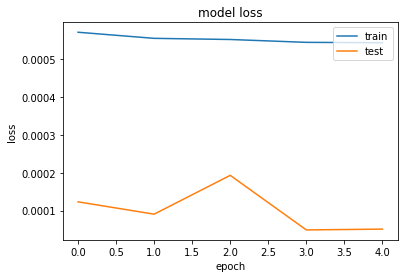

In [24]:
####################################################################################
# PASO 16: Realiza el entrenamiento de la red
num_epochs = 20
nb_epoch = 5
  
try:
  # ejecuta cada 'nb_epoch' hasta un total de 'num_epochs'
  for i in range(0, num_epochs, nb_epoch):        
    print('\r\n--------------------\r\nIniciando entrenamiento en epoch=',epoch_count)
    train_x = x_train.reshape(x_train.shape[0], num_in_steps, num_inputs)
    train_y = y_train.reshape(y_train.shape[0], num_out_steps * num_outputs)
    validation_x = x_validation.reshape(x_validation.shape[0], num_in_steps, num_inputs)
    validation_y = y_validation.reshape(y_validation.shape[0], num_out_steps * num_outputs)
    history = model.fit(train_x, train_y, epochs=nb_epoch, batch_size=batch_size, callbacks=callbacks_list, validation_data=(validation_x,validation_y), verbose=2, shuffle=True) 
    epoch_count += nb_epoch
except:
  print('Model fit Exception:', sys.exc_info()[0])



# visualizo el resultado de la ejecución de la celda actual
plt.plot(callbacks_list[1].loss[:])
plt.plot(callbacks_list[1].val_loss[:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

  


In [31]:
history.history

{'val_loss': [0.00012322540117057433,
  9.0611533690955e-05,
  0.00019331489269773855,
  4.8937912068911034e-05,
  5.1058054371975616e-05],
 'val_acc': [0.4993806450841697,
  0.5101914564776864,
  0.511542808151225,
  0.48141893259299967,
  0.48434686113929226],
 'loss': [0.0005719491584925805,
  0.0005558104535654169,
  0.0005527711224991939,
  0.0005452088625156188,
  0.00054421061007803],
 'acc': [0.4983812084128904,
  0.5017032806660879,
  0.5009994515110865,
  0.5011683705316328,
  0.5009572219506309]}

In [173]:
if ENABLE_GOOGLE_COLAB:
  files.download(file_weights)


# VERIFICACIÓN

##### Chequeo el resultado de aplicar el conjunto de test para obtener el par (Loss, Accuracy)

In [19]:
# Evalúa el funcionamiento con la partición de test
test_x = x_test.reshape(x_test.shape[0], num_in_steps, num_inputs)
test_y = y_test.reshape(y_test.shape[0], num_out_steps * num_outputs)            
scores = model.evaluate(test_x, test_y, verbose=2)
print('Model Loss: ', scores[0])  
print("Model Accuracy: %.2f%%" % (scores[1]*100))

Model Loss:  8.874458806207968e-05
Model Accuracy: 49.86%


##### Proceso todo el conjunto de test para obtener el error RMSE y las gráficas de resultado (Target vs Prediction)

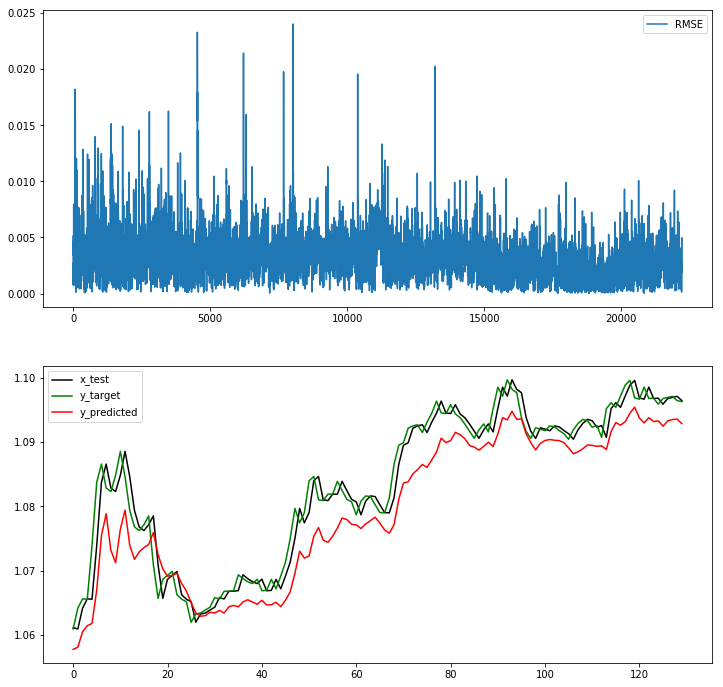

In [20]:
x_data = test_x
y_data = test_y

rmse = list()
inp,target,pred=list(),list(),list()
for sample in range(x_data.shape[0]):
    # Realizo predicción del primer conjunto de datos
    x = x_data[sample].reshape(1, num_in_steps, num_inputs)
    y = y_data[sample].reshape(1,num_outputs * num_out_steps)
    predictions = model.predict(x, batch_size=1,verbose=0)

    # deshago el scaling
    xy_values = np.concatenate((x.reshape(1, x.shape[1]*x.shape[2]), y),axis=1)
    xy_values = scaler.inverse_transform(xy_values)
    xyhat_values = np.concatenate((x.reshape(1, x.shape[1]*x.shape[2]), predictions),axis=1)
    xyhat_values = scaler.inverse_transform(xyhat_values)

    # Calculo el error RMSE
    rmse_val = math.sqrt(sk.mean_squared_error(xy_values[0,-(num_outputs * num_out_steps):], xyhat_values[0,-(num_outputs * num_out_steps):], multioutput = 'uniform_average'))
    rmse.append(rmse_val)
    inp.append(xy_values[0,-(num_outputs * num_out_steps)-1])
    target.append(xy_values[0,-(num_outputs * num_out_steps)])
    pred.append(xyhat_values[0,-(num_outputs * num_out_steps)])    

plt.figure(figsize=(12,12))
plt.subplot(2,1,1)
plt.plot(np.asarray(rmse))    
plt.legend(['RMSE'])
plt.subplot(2,1,2)
# visualizo los resultados anteriores en un rango dado
i,j = 70,200
plt.plot(np.asarray(inp).reshape((len(inp),))[i:j],color='black')
plt.plot(np.asarray(target).reshape((len(target),))[i:j],color='green')
plt.plot(np.asarray(pred).reshape((len(pred),))[i:j],color='red')
plt.legend(['x_test', 'y_target', 'y_predicted'])



##### Proceso un slice de test con predicciones parciales

[1.06328 1.06342] [1.0634338 1.0633464]
[1.06877 1.06829] [1.0651455 1.0650668]
[1.075   1.07967] [1.0667112 1.0666394]
[1.08388 1.08245] [1.076633  1.0765738]
[1.07898 1.0813 ] [1.0763236 1.076258 ]


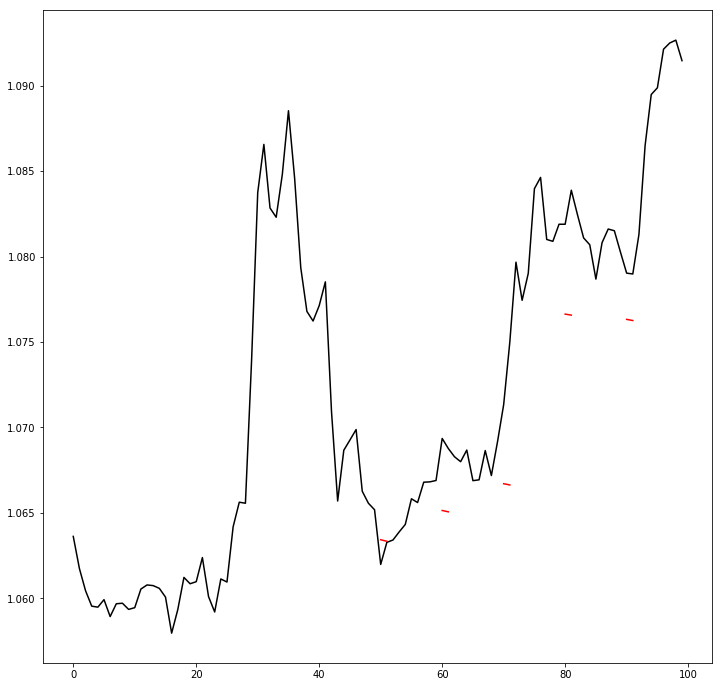

In [30]:
x_data = test_x
y_data = test_y

isample = num_in_steps
num_samples = 100
step = 10

target_vals,pred_vals, pred_idx=list(),list(),list()
for s in range(num_samples):
    sample = isample+s
    # Realizo predicción del primer conjunto de datos
    x = x_data[sample].reshape(1, num_in_steps, num_inputs)
    y = y_data[sample].reshape(1,num_outputs * num_out_steps)
    predictions = model.predict(x, batch_size=1,verbose=0)

    # deshago el scaling
    xy_values = np.concatenate((x.reshape(1, x.shape[1]*x.shape[2]), y),axis=1)
    xy_values = scaler.inverse_transform(xy_values)
    xyhat_values = np.concatenate((x.reshape(1, x.shape[1]*x.shape[2]), predictions),axis=1)
    xyhat_values = scaler.inverse_transform(xyhat_values)

    # Calculo el error RMSE
    target_vals.append(xy_values[0,-(num_outputs * num_out_steps)-1])
    if s>=num_in_steps and s % step == 0:
        print(xy_values[0,-(num_outputs * num_out_steps):], xyhat_values[0,-(num_outputs * num_out_steps):])
        pred_vals.append(xyhat_values[0,-(num_outputs * num_out_steps):])    
        pred_idx.append(s)

plt.figure(figsize=(12,12))
plt.plot(np.asarray(target_vals).reshape((len(target_vals),)),color='black')
for i in range(len(pred_vals)):
    values = np.asarray(pred_vals[i])
    pos = np.arange(pred_idx[i], pred_idx[i]+values.shape[0])
    plt.plot(pos, values, color='r')


### VERIFICACIÓN CON PREDICCIÓN REALIMENTADA

##### Como experimento, a partir de un dato de test, genero una predicción y la voy realimentando como entrada durante un nº de veces, para ver si la predicción se va desviando de la señal objetivo

sample 1 de 100


C:\Users\raulm\Programas\anaconda3\envs\keras\lib\site-packages\ipykernel\__main__.py:44: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



sample 2 de 100
sample 3 de 100
sample 4 de 100
sample 5 de 100
sample 6 de 100
sample 7 de 100
sample 8 de 100
sample 9 de 100
sample 10 de 100
sample 11 de 100
sample 12 de 100
sample 13 de 100
sample 14 de 100
sample 15 de 100
sample 16 de 100
sample 17 de 100
sample 18 de 100
sample 19 de 100
sample 20 de 100
sample 21 de 100
sample 22 de 100
sample 23 de 100
sample 24 de 100
sample 25 de 100
sample 26 de 100
sample 27 de 100
sample 28 de 100
sample 29 de 100
sample 30 de 100
sample 31 de 100
sample 32 de 100
sample 33 de 100
sample 34 de 100
sample 35 de 100
sample 36 de 100
sample 37 de 100
sample 38 de 100
sample 39 de 100
sample 40 de 100
sample 41 de 100
sample 42 de 100
sample 43 de 100
sample 44 de 100
sample 45 de 100
sample 46 de 100
sample 47 de 100
sample 48 de 100
sample 49 de 100
sample 50 de 100
sample 51 de 100
sample 52 de 100
sample 53 de 100
sample 54 de 100
sample 55 de 100
sample 56 de 100
sample 57 de 100
sample 58 de 100
sample 59 de 100
sample 60 de 100
sampl

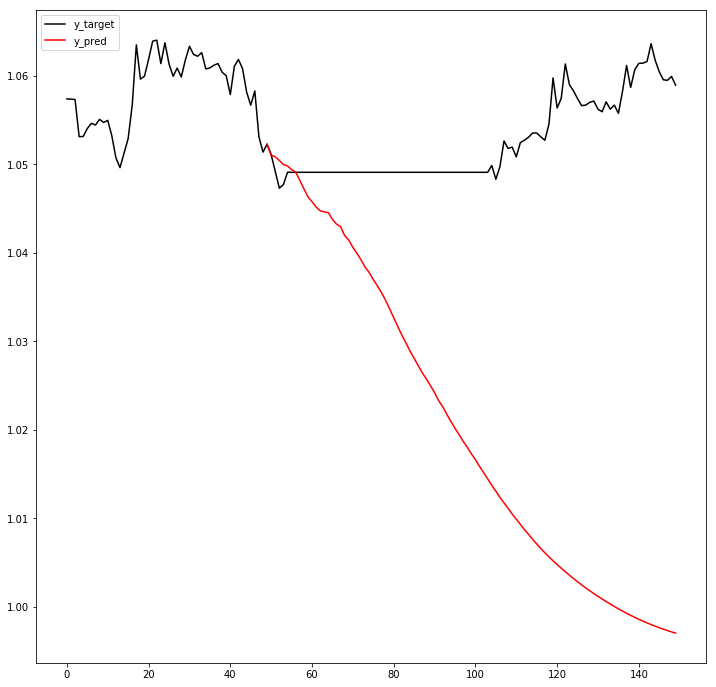

In [32]:
# @@@@@@@@@@@@@@@ CONFIG_SETUP

print_logs = False              # Flag para activar trazas de depuración de esta celda
test_len = 100                   # Establezco el número de muestras a futuro para realizar el test
predict_with_ctrol=True         # Establezco el modo de predicción (con o sin control)
ctrol_wdow = trvl_samples       # Establezco la ventana del dataframe 'df' a seleccionar (df[:-ctrol_wdow])
ctrol_wdow_prev=50              # Nº de muestras previas de control a visualizar
add_first_steps=False           # Flag para añadir las num_out_steps filas al final de dfpred antes del test

setup_test_with_ctrol=(False,24,True,trvl_samples,100,False)
setup_test_with_ctrol_no_previous=(False,24,True,trvl_samples,1,False)
setup_predict_future=(False,24,False,0,100,True)
setup_predict_future_noadd_steps=(False,24,False,0,100,False)

# @@@@@@@@@@@@@@@


# dpred contiene una copia del dataframe origen 'df' que puede ser:
# 1. Modo predicción con control de resultado (si dfpred+test_len es un slice de df)
# 2. Modo predicción a futuro real (si dfpred es una copia exacta de df)
dfpred = df.copy()
if add_first_steps:
  delta = dfpred.index[1] - dfpred.index[0]
  max_index = dfpred.index[-1] + (num_out_steps * delta)
  new_index = pd.date_range(min(dfpred.index), max_index, freq="1H")
  dfpred = dfpred.reindex(new_index)
  dfpred.loc[-num_out_steps:,:]=0   
    
control_data = dfpred[dfpred.shape[0] - num_out_steps-ctrol_wdow_prev:dfpred.shape[0] - num_out_steps].values
if predict_with_ctrol:
  dfpred = df.loc[df.index <= sts_src.index[ctrol_wdow+num_out_steps]].copy()
  control_data = df[dfpred.shape[0] - num_out_steps-ctrol_wdow_prev:dfpred.shape[0] - num_out_steps+test_len].values
    
# inicio sin ninguna predicción
ypred = np.nan

# creo lista para almacenar las predicciones de la red 
pred = list()

# para cada muestra de test
for sample in range(test_len):    
  # si hay muestra predicha del paso anterior, la reinserto como una nueva muestra actual
  if not np.isnan(ypred):
    dfpred.iloc[-num_out_steps]['CLOSE'] = ypred
    # añado una nueva fila al final y pongo sus valores a 0
    delta = dfpred.index[1] - dfpred.index[0]
    max_index = dfpred.index[-1] + delta
    new_index = pd.date_range(min(dfpred.index), max_index, freq="1H")
    dfpred = dfpred.reindex(new_index)
    dfpred.loc[-num_out_steps:,:]=0

  # en este punto dfpred es el dataframe original con 'num_out_steps' filas al final todas a 0.
  # añado indicadores técnicos
  dfapp_pred = add_indicators(dfpred, 'out',['CLOSE'], columns_to_include, columns_to_exclude, indicators_to_generate, remove_weekends=True, add_applied=True)
  
  # en este punto dfapp_pred es el dataframe con todos los indicadores técnicos
  # creo modelo con formato de entrenamiento supervisado para el scaler
  sts_src_pred = series_to_supervised(dfapp_pred, num_inputs, num_outputs, num_in_steps, num_out_steps)

  # en este punto sts_src_pred tiene todos los datos listos antes de la normalización con 'scaler'   
  # normalizo los datos
  sts_src_pred_values = sts_src_pred.values
  sts_src_pred_values = values.astype('float32')
  sts_src_pred_scaled_values = scaler.transform(sts_src_pred_values)
  sts_scaled_pred = pd.DataFrame(data=sts_src_pred_scaled_values, columns=sts_src_pred.columns, index=sts_src_pred.index)
  sts_scaled_pred_values = sts_scaled_pred.values

  # en este punto sts_scaled_pred tiene los valores listos para la red neuronal
  # genero una predicción
  x = sts_scaled_pred_values[-1,0:num_inputs*num_in_steps].reshape(1, num_in_steps, num_inputs)
  predictions = model.predict(x, batch_size=1,verbose=0)
  
  # en este punto ya tengo la siguiente predicción
  # deshago el scaling
  xyhat_values = np.concatenate((x.reshape(1, x.shape[1]*x.shape[2]), predictions),axis=1)
  xyhat_values = scaler.inverse_transform(xyhat_values)
    
  # en este punto tengo el valor denormalizado de la predicción
  # guardo la última entrada aplicada y la predicción en t+1 para repetir el bucle
  xreal = xyhat_values[0,-(num_outputs*num_out_steps)-1]
  if np.isnan(ypred):
    pred.append(xreal)
  ypred = xyhat_values[0,num_inputs*num_in_steps]  
  pred.append(ypred)  
  print('sample {} de {}'.format(sample+1, test_len))


y_pred = np.asarray(pred).reshape((len(pred),))
x_pred_idx = np.arange(ctrol_wdow_prev-1,ctrol_wdow_prev-1+y_pred.shape[0])
x_previous = control_data['CLOSE'].values
#y_trgt = np.asarray(targets).reshape((len(targets),))

plt.figure(figsize=(12,12)) 
plt.plot(np.arange(x_previous.shape[0]),x_previous, color='black')
plt.plot(x_pred_idx, y_pred, color='r')
if predict_with_ctrol:
  plt.legend(['y_target','y_pred'])
else:
  plt.legend(['x','y_pred'])


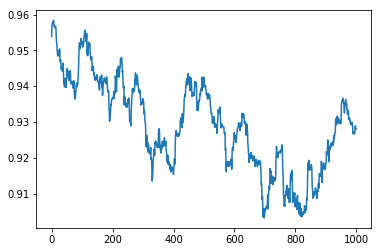

In [36]:
# en este punto dfpred es el dataframe original con 'num_out_steps' filas al final todas a 0.
# añado indicadores técnicos
dfpred = df.copy()
dfapp_pred = add_indicators(dfpred, 'out',['CLOSE'], columns_to_include, indicators_to_generate, remove_weekends=True, add_applied=True)
# quito la columna weekday ya que no la utilizo. Antes era necesaria para eliminar los weekends
dfapp_pred = dfapp_pred.drop('weekday',axis=1)

# en este punto dfapp_pred es el dataframe con todos los indicadores técnicos
# creo modelo con formato de entrenamiento supervisado para el scaler
sts_src_pred = series_to_supervised(dfapp_pred, num_inputs, num_outputs, num_in_steps, num_out_steps)
_values = sts_src_pred['out(t+1)'][0:1000].values
# en este punto sts_src_pred tiene todos los datos listos antes de la normalización con 'scaler'   
# normalizo los datos
plt.plot(_values)